In [109]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

In [3]:
tickers = ['AAPL','TSLA','DIA','SPY','^TNX']

start_date = '2000-01-01'
end_date = '2020-12-31'

In [4]:
import yfinance as yf

tickerlist = []

for ticker in tickers:
    tickerinfo = {}
    tickerinfo['ticker'] = ticker
    tickerinfo['name'] = yf.Ticker(ticker).info['shortName']
    tickerinfo['marketCap'] = yf.Ticker(ticker).info['marketCap']
    tickerlist.append(tickerinfo)
    
tickerlist = pd.DataFrame(tickerlist)
tickerlist.set_index('ticker', inplace=True)

In [5]:
data = yf.download(tickers, start=start_date, end=end_date)
prices = data['Adj Close'][tickers].dropna()

[*********************100%***********************]  5 of 5 completed


In [6]:
data.columns

MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close',  'DIA'),
            ('Adj Close',  'SPY'),
            ('Adj Close', 'TSLA'),
            ('Adj Close', '^TNX'),
            (    'Close', 'AAPL'),
            (    'Close',  'DIA'),
            (    'Close',  'SPY'),
            (    'Close', 'TSLA'),
            (    'Close', '^TNX'),
            (     'High', 'AAPL'),
            (     'High',  'DIA'),
            (     'High',  'SPY'),
            (     'High', 'TSLA'),
            (     'High', '^TNX'),
            (      'Low', 'AAPL'),
            (      'Low',  'DIA'),
            (      'Low',  'SPY'),
            (      'Low', 'TSLA'),
            (      'Low', '^TNX'),
            (     'Open', 'AAPL'),
            (     'Open',  'DIA'),
            (     'Open',  'SPY'),
            (     'Open', 'TSLA'),
            (     'Open', '^TNX'),
            (   'Volume', 'AAPL'),
            (   'Volume',  'DIA'),
            (   'Volume',  'SPY'),
            (   'Vol

In [7]:
tickerlist

,name,marketCap
ticker,,
AAPL,Apple Inc.,2.174190e+12
TSLA,"Tesla, Inc.",6.002583e+11
DIA,SPDR Dow Jones Industrial Avera,NaN
SPY,SPDR S&P 500,NaN
^TNX,CBOE Interest Rate 10 Year T No,NaN


---
## Risk Free Rate - 10 Year Treasury Yield

In [8]:
rfr = prices['^TNX']/100
print('Risk Free Rate: {:.3f}%'.format(rfr[-1]*100))

Risk Free Rate: 0.923%


In [9]:
rfr_monthly = rfr.resample('M').fillna('ffill')
rfr_monthly.index = rfr_monthly.index.to_period('M')

## Black Littleman - Investor's Risk Aversion Parameters

In [10]:
sp500 = prices['SPY']
djia = prices['DIA']

In [11]:
def calcDelta(px, freq='M', rfr=0.00):
    px_freq = px.resample(freq).fillna('ffill')
    px_freq.index = px_freq.index.to_period(freq)
    rets = px_freq.pct_change().dropna()
    return (rets.mean()-rfr)/rets.var()

In [12]:
calcDelta(sp500, 'Y', rfr[-1])

8.770683990457997

In [13]:
calcDelta(djia, 'Y', rfr[-1])

9.377776023645474

In [14]:
# delta = sp500.pct_change().dropna().rolling(252).mean()/sp500.pct_change().dropna().rolling(252).var()
# delta.dropna(inplace=True)
# delta.name = 'Delta'

# p = pd.concat([sp500, delta], axis=1).dropna()
# p.SPY.plot(figsize=(12,6), legend=True)
# p.Delta.plot(legend=True, secondary_y=True)
# plt.show()

In [15]:
calcDelta(sp500['2007':], 'M')

8.009258979527472

## Prices

In [16]:
def calcRetsCov(px, freq):
    px_freq = px.resample(freq).fillna('ffill')
    px_freq.index = px_freq.index.to_period(freq)

    rets = px_freq.pct_change().dropna()
    cov = rets.cov()
    return rets, cov

In [17]:
to_drop = ['^TNX','DIA','SPY']
px = prices.drop(to_drop, axis=1)

In [18]:
rets_monthly, cov_monthly = calcRetsCov(px, 'M')

In [19]:
rfr_period = rfr_monthly
rets_period = rets_monthly
PERIODS_PER_YEAR = 12

erk.summary_stats(rets_period, riskfree_rate=rfr_period[-1], 
                  periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False) \
            .style.bar(color=['pink', 'lightgreen'], align='zero')

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
AAPL,0.307053,0.273130,-0.118396,2.768716,0.106552,0.134159,1.081232,-0.395421
TSLA,0.593054,0.640788,1.447372,6.150033,0.154349,0.213271,0.903339,-0.487957


## Equilibrium Expected Returns

In [20]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir


## Black Litterman Model

In [60]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)


from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w

## Portfolio Parameters

In [21]:
DELTA = 2.5

In [47]:
wgts_prior = tickerlist.marketCap.dropna()/sum(tickerlist.marketCap.dropna())
wgts_prior

ticker
AAPL    0.783648
TSLA    0.216352
Name: marketCap, dtype: float64

In [48]:
cov_monthly

,AAPL,TSLA
AAPL,0.006217,0.004292
TSLA,0.004292,0.034217


Implied returns given the benchmark wgts (market cap wgts) and covariance matrix

## Equilibrium Implied Returns

In [53]:
s = cov_monthly
pi = implied_returns(delta=DELTA, sigma=s, w=wgts_prior)
pi

AAPL    0.014501
TSLA    0.026916
Name: Implied Returns, dtype: float64

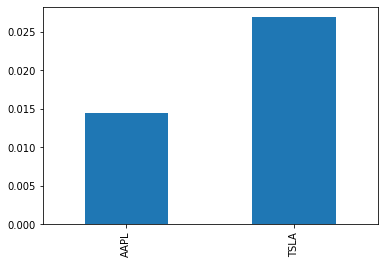

In [88]:
pi.plot(kind='bar')
plt.show()

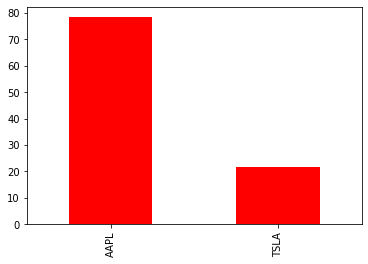

In [114]:
tickers = pi.index
er_appl = pi[0]
er_tsla = pi[1]

mu_exp = pd.Series([er_appl, er_tsla], index=tickers)
msr_w = np.round(w_msr(s, mu_exp)*100, 2)

msr_w.plot(kind='bar', color='r')
plt.show()

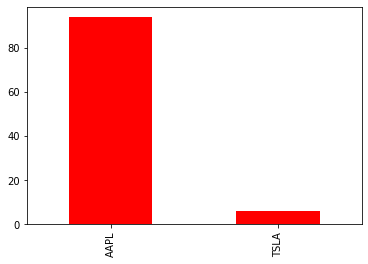

In [125]:
tickers = pi.index
er_appl = 0.01
er_tsla = 0.01

mu_exp = pd.Series([er_appl, er_tsla], index=tickers)
excess_mu = mu_exp
msr_w = np.round(w_msr(s, mu_exp)*100, 2)

msr_w.plot(kind='bar', color='r')
plt.show()

In [151]:
def show_combine_wgts(er1, er2):
    
    tickers = pi.index

    mu_exp = pd.Series([er1, er2], index=tickers)
    msr_w = w_msr(s, mu_exp)
    
    combine_wgts = pd.concat([wgts_prior, msr_w], axis=1)
    combine_wgts = combine_wgts * 100
    combine_wgts.columns = ['bmk', 'wgts_with_views']
    ax = combine_wgts.plot(kind='bar', figsize=(12,6))
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.075, p.get_height() + 0.5))

### CONTROLS
combine_wgts_controls = widgets.interactive(show_combine_wgts,
                    er1=widgets.FloatSlider(min=0, max=.1, step=0.01, value=pi[0], description='AAPL'),
                    er2=widgets.FloatSlider(min=0, max=.1, step=0.01, value=pi[1], description='TSLA')
                    )    

### DISPLAY
display(combine_wgts_controls)

interactive(children=(FloatSlider(value=0.01450056886683352, description='AAPL', max=0.1, step=0.01), FloatSli…

## Black Litterman Asset Allocation Model
### Absolute View

In [65]:
tickers = pi.index
er_appl = 0.01
er_tsla = 0.04

q = pd.Series([er_appl, er_tsla], index=tickers)
q

AAPL    0.01
TSLA    0.04
dtype: float64

In [66]:
p = pd.DataFrame(np.identity(len(q)).astype(int), columns=tickers)
p

,AAPL,TSLA
0,1,0
1,0,1


In [67]:
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
# Black Litterman Implied Mu
bl_mu

AAPL    0.012719
TSLA    0.032519
dtype: float64

In [68]:
# Use the Black Litterman expected returns to get the Optimal Markowitz weights
w_msr(bl_sigma, bl_mu)

AAPL    0.66716
TSLA    0.33284
dtype: float64

In [156]:
def show_bl_wgts_abs_views(er1, er2):
    
    tickers = pi.index
    
    mu_exp = pd.Series([er1, er2], index=tickers)
    native_w = w_msr(s, mu_exp)
    
    q = pd.Series([er1, er2], index=tickers)
    p = pd.DataFrame(np.identity(len(q)).astype(int), columns=tickers)

    bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
    bl_w = w_msr(bl_sigma, bl_mu)
    
    combine_wgts = pd.concat([wgts_prior, native_w, bl_w], axis=1)
    combine_wgts = combine_wgts * 100
    combine_wgts.columns = ['bmk', 'naive_wgts_with_views', 'bl_wgts_with_views']
    ax = combine_wgts.plot(kind='bar', figsize=(12,6))
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.04, p.get_height() + 0.5))

### CONTROLS
combine_wgts_controls = widgets.interactive(show_bl_wgts_abs_views,
                    er1=widgets.FloatSlider(min=0, max=.1, step=0.01, value=pi[0], description='AAPL'),
                    er2=widgets.FloatSlider(min=0, max=.1, step=0.01, value=pi[1], description='TSLA')
                    )    

### DISPLAY
display(combine_wgts_controls)

interactive(children=(FloatSlider(value=0.01450056886683352, description='AAPL', max=0.1, step=0.01), FloatSli…

### Relative View

In [69]:
pi

AAPL    0.014501
TSLA    0.026916
Name: Implied Returns, dtype: float64

In [74]:
q = pd.Series([
# Relative View 1: INTC will outperform PFE by 2%
  0.02
    ]
)
# The Pick Matrix
p = pd.DataFrame([
  # For View 1, this is for INTC outperforming PFE
  {'AAPL': -1, 'TSLA': 1}
])

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
# Black Litterman Implied Mu
bl_mu


AAPL    0.014271
TSLA    0.030479
dtype: float64

In [75]:
pi[0]-pi[1]

-0.01241510421198086

In [76]:
bl_mu[0]-bl_mu[1]

-0.01620755210599043

In [78]:
# Use the Black Litterman expected returns and covariance matrix
excess_mu = bl_mu - rfr_period[-1]
np.round(w_msr(bl_sigma, excess_mu)*100, 2)

AAPL    41.89
TSLA    58.11
dtype: float64

In [82]:
wgts_msr = erk.msr(rfr_period[-1], bl_mu, bl_sigma, longonly=False)
wgts_msr = pd.Series(wgts_msr, index=tickers)
np.round(wgts_msr*100, 2)

AAPL    42.05
TSLA    57.95
dtype: float64

In [163]:
def show_bl_wgts_rel_views(rr):
    
    tickers = pi.index
    
    q = pd.Series([rr])
    p = pd.DataFrame([
      {'AAPL': 1, 'TSLA': -1}
    ])

    bl_mu, bl_sigma = bl(w_prior=wgts_prior, sigma_prior=s, p=p, q=q)
    bl_w = w_msr(bl_sigma, bl_mu)
    
    combine_wgts = pd.concat([wgts_prior, bl_w], axis=1)
    combine_wgts = combine_wgts * 100
    combine_wgts.columns = ['bmk', 'bl_wgts_with_views']
    ax = combine_wgts.plot(kind='bar', figsize=(12,6))
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + 0.04, p.get_height() + 0.5))

### CONTROLS
combine_wgts_controls = widgets.interactive(show_bl_wgts_rel_views,
                    rr=widgets.FloatSlider(min=-0.1, max=.1, step=0.01, value=pi[0]-pi[1], description='A vs T')
                    )    

### DISPLAY
display(combine_wgts_controls)

interactive(children=(FloatSlider(value=-0.01241510421198086, description='A vs T', max=0.1, min=-0.1, step=0.…

## Adjustments
- $\tau$: A scalar indicating the uncertainty of the prior.  A common technique is to set $\tau = 1/T$ where $T$ is the number of periods of data used.  
- $\delta$: The investor's risk aversion parameter (default is 2.5)
- $\Omega$: $diag(P (\tau \Sigma) P^T) $

In [85]:
omega = proportional_prior(s, 0.02, p)

In [86]:
omega

,0
0,0.000637
